In [1]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from bnn_definition import NeuralNetwork

**Load Boston and Normalize**

In [2]:
boston = load_boston()

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [4]:
data = pd.DataFrame(scaler.fit_transform(boston['data']), columns=boston['feature_names'])

In [5]:
data['target'] = boston['target']

**Split to Test and Training**

In [6]:
build_columns = data.columns.tolist()
build_columns.remove('target')

In [7]:
Xt, Xv, yt, yv = train_test_split(data[build_columns], data['target'],
                                  test_size=0.2, random_state=42)

Convert to Torch Variables

In [8]:
# convert to pytorch tensors
train_X = Variable(torch.from_numpy(Xt.values).float())
train_Y = Variable(torch.from_numpy(yt.values).float(), requires_grad=False)
        
test_X = Variable(torch.from_numpy(Xv.values).float())
test_Y = Variable(torch.from_numpy(yv.values).float(), requires_grad=False).view(-1, 1)

**Train Network; (use only test/validate sets due to small data size)**

In [9]:
model = NeuralNetwork(input_dim=train_X.size()[1], hidden_1=128)
model.apply(NeuralNetwork.init_weights)

NeuralNetwork(
  (linear_1): Linear(in_features=13, out_features=128, bias=True)
  (linear_2): LinearCustomDropout(
    in_features=128, out_features=1, bias=True
    (dropout_mask): Dropout(p=0.05)
  )
  (relu): ReLU()
)

In [10]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [11]:
epoch_loss = []
mse_test_list = []
mse_train_list = []
epoch_loss_list = []

early_stopping_epochs = 3
early_stopping = 0.0001
batch_size = 128

In [12]:
# train the network
for t in range(500):
    
    # in this case the order of the dataset is preserved; it is not important
    # for this example
    permutation = torch.from_numpy(np.asarray([i for i in range(len(train_X))]))
    epoch_loss = 0

    # for each batch
    for idx, i in enumerate(range(0, train_X.size()[0], batch_size)):

        indices = permutation[i: i+batch_size-1]
        batch_x, batch_y = train_X[indices], train_Y[indices].view(-1, 1)

        # forward pass
        y_pred_batch = model(batch_x)

        # compute loss
        loss = criterion(y_pred_batch, batch_y)

        # get epoch loss
        epoch_loss += loss.item()

        # zeroing gradients, backward pass and weights update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # compute accuracty and various other metrics for epoch
    # function model.predict_() returns 100 predictions from Bayesian Neural Network
    test_preds, _ = model.predict_(test_X)
    test_preds = Variable(torch.from_numpy(test_preds.reshape(-1, 1)).float())
    
    train_preds, _ = model.predict_(train_X)
    train_preds = Variable(torch.from_numpy(train_preds.reshape(-1, 1)).float())

    # test set
    mse_test = mean_squared_error(test_Y.data.numpy(), test_preds.data.numpy())
    mse_test_list.append(mse_test)
    if t % 20 == 0:
        print('test set mse:', mse_test, 'epoch: {0}'.format(t))

    # train set
    mse_train = mean_squared_error(train_Y.data.numpy(), train_preds.data.numpy())
    mse_train_list.append(mse_train)
    if t % 20 == 0:
        print('train set mse:', mse_train, 'epoch: {0}'.format(t))

    # epoch loss
    epoch_loss_list.append(epoch_loss/idx)

    # EARLY STOPPING. Stop training if the difference between last n epochs is less that tolerance
    if len(epoch_loss_list) > early_stopping_epochs:
        if max([x[1]-x[0] for x in zip(epoch_loss_list[1:], epoch_loss_list[:-1])][-early_stopping_epochs:]) <= early_stopping:
            print('Training Stopped by Early Stopping!')
            break

test set mse: 535.90875 epoch: 0
train set mse: 607.29083 epoch: 0
test set mse: 317.28723 epoch: 20
train set mse: 375.1697 epoch: 20
test set mse: 127.0097 epoch: 40
train set mse: 154.71156 epoch: 40
test set mse: 102.02333 epoch: 60
train set mse: 116.98978 epoch: 60
test set mse: 79.754715 epoch: 80
train set mse: 92.83938 epoch: 80
test set mse: 62.39694 epoch: 100
train set mse: 74.42042 epoch: 100
test set mse: 53.05423 epoch: 120
train set mse: 62.58024 epoch: 120
test set mse: 48.037746 epoch: 140
train set mse: 55.7124 epoch: 140
test set mse: 44.588394 epoch: 160
train set mse: 51.388638 epoch: 160
test set mse: 42.994717 epoch: 180
train set mse: 47.906742 epoch: 180
Training Stopped by Early Stopping!


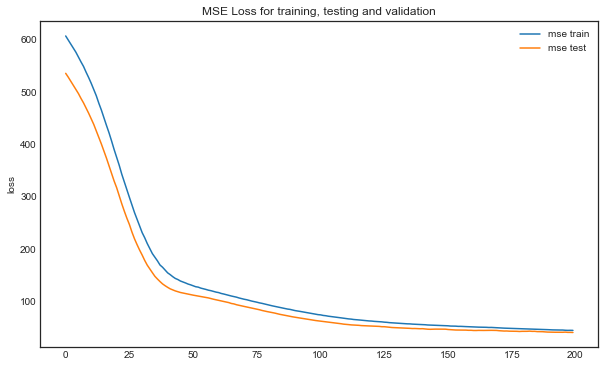

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(mse_train_list, label='mse train',)
plt.plot(mse_test_list, label='mse test')
plt.ylabel('loss')
plt.legend()
plt.title('MSE Loss for training, testing and validation')
plt.show()

**Plot BNN Predictions**

In [14]:
nn_preds, b = model.predict_(Variable(test_X.float()), n_preds=500)

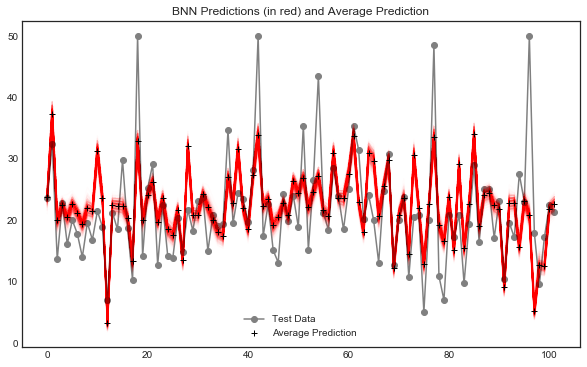

In [15]:
plt.figure(figsize=(10, 6))
plt.title('BNN Predictions (in red) and Average Prediction')
plt.plot(test_Y.data.numpy(), '-o', label='Test Data', color='grey')
plt.plot(b, alpha=0.01, color='r')
plt.plot(nn_preds, '+', label='Average Prediction', color='k')
plt.legend()
plt.show()

Here we predictions of Baysian Neural Network (in red) obtained using dropout in both training and predicting. To adjust the size of a dropout, see line 44 in the `bnn_definition.py` file. The model is not doing great on Boston Dataset; it is used to illustrate how BNN could be used.

Based on:
1. https://github.com/yaringal/DropoutUncertaintyExps </b>
2. http://mlg.eng.cam.ac.uk/yarin/thesis/thesis.pdf